In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

%load_ext autoreload   
%autoreload 2

#Autoreloading of modules so you don't have to restart kernel after editing .py files

In [2]:
# import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tf.enable_eager_execution()
import random
import matplotlib.pyplot as plt
import numpy as np
from miniscope_utils_tf import *
#import utils as krist
import scipy.misc as sc
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import scipy.ndimage as ndim
import scipy.misc as misc
from scipy import signal
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
from os import listdir
from os.path import isfile, join
import os
import time
from itertools import permutations
from itertools import combinations
#import copy
#from bridson import poisson_disc_samples


In [3]:
#device = '/gpu:0'
#print(tf.test.is_gpu_available())
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [12]:
#model and loss
class Model(tf.keras.Model):
    def __init__(self, zsampling = 'uniform_random', cross_corr_norm = 'log_sum_exp'):   #'log_sum_exp'
        super(Model, self).__init__()
        
        self.samples = (768,768)   #Grid for PSF simulation

        # min and max lenslet focal lengths in mm
        self.fmin = 6.
        self.fmax = 20.
        self.ior = 1.56
        self.lam=510e-6
        
        # Min and max lenslet radii
        self.Rmin = self.fmin*(self.ior-1.)
        self.Rmax = self.fmax*(self.ior-1.)

        # Convert to curvatures
        self.cmin = 1/self.Rmax
        self.cmax = 1/self.Rmin
        self.xgrng = np.array((-1.8, 1.8)).astype('float32')    #Range, in mm, of grid of the whole plane (not just grin)
        self.ygrng = np.array((-1.8, 1.8)).astype('float32')

        self.t = 10.    #Distance to sensor from mask in mm

        #Compute depth range of virtual image that mask sees (this is assuming an objective is doing some magnification)

        self.zmin_virtual = 1./(1./self.t - 1./self.fmin)
        self.zmax_virtual = 1./(1./self.t - 1./self.fmax)
        self.CA = .9; #semi clear aperature of GRIN
        self.mean_lenslet_CA = .2 #average lenslest semi clear aperture in mm. 
            
        #Getting number of lenslets and z planes needed as well as defocus list
        self.ps = (self.xgrng[1] - self.xgrng[0])/self.samples[0]
        self.Nlenslets=np.int(np.floor((self.CA**2)/(self.mean_lenslet_CA**2)))
        self.Nz = np.ceil(np.sqrt(self.Nlenslets*2)).astype('int') #number of Zplanes 
        self.zsampling = zsampling
        self.grid_z_planes=20
        #self.defocus_grid=  1./(np.linspace(1/self.zmin_virtual, 1./self.zmax_virtual, self.grid_z_planes)) #mm or dioptres

        #if self.zsampling is 'fixed':
        #    self.defocus_list = 1./(np.linspace(1/self.zmin_virtual, 1./self.zmax_virtual, self.Nz)) #mm or dioptres
            
        self.min_offset= -10e-3
        self.max_offset= 10e-3
        self.lenslet_offset=tfe.Variable(tf.zeros(self.Nlenslets),name='offset', dtype = tf.float32,constraint=lambda t: tf.clip_by_value(t,self.min_offset, self.max_offset))
        #initializing the x and y positions
        [xpos,ypos, rlist]=poissonsampling_circular(self)
        
        self.min_r= self.Rmin
        self.max_r= self.Rmax
        self.rlist = tfe.Variable(rlist,name='rlist', dtype = tf.float32,constraint=lambda t: tf.clip_by_value(t,self.min_r, self.max_r))
        #self.xpos = tfe.Variable(xpos, name='xpos', dtype = tf.float32, constraint=lambda t: tf.clip_by_value(t,-self.CA, self.CA))
        #self.ypos = tfe.Variable(ypos, name='ypos', dtype = tf.float32, constraint=lambda t: tf.clip_by_value(t,-self.CA, self.CA))
        self.xpos = tfe.Variable(xpos, name='xpos', dtype = tf.float32)
        self.ypos = tfe.Variable(ypos, name='ypos', dtype = tf.float32)
        #parameters for making the lenslet surface
        self.yg = tf.constant(np.linspace(self.ygrng[0], self.ygrng[1], self.samples[0]),dtype=tf.float32)
        self.xg=tf.constant(np.linspace(self.xgrng[0], self.xgrng[1], self.samples[1]),dtype=tf.float32)
        self.px=tf.constant(self.xg[1] - self.xg[0],tf.float32)
        self.py=tf.constant(self.yg[1] - self.yg[0],tf.float32)
        self.xgm, self.ygm = tf.meshgrid(self.xg,self.yg)

        #PSF generation parameters
        self.lam=tf.constant(510.*10.**(-6.),dtype=tf.float32)
        self.k = np.pi*2./self.lam
        
        fx = tf.constant(np.linspace(-1./(2.*self.ps),1./(2.*self.ps),self.samples[1]),dtype=tf.float32)
        fy = tf.constant(np.linspace(-1./(2.*self.ps),1./(2.*self.ps),self.samples[0]),dtype=tf.float32)
        self.Fx,self.Fy = tf.meshgrid(fx,fy)
        self.field_list = tf.constant(np.array((0., 0.)).astype('float32'))
        
        self.corr_pad_frac = .5
        self.target_res = 2.5# micron   
        sig = 2*self.target_res/(2.355) * 1e-3
        real_target = tf.exp(-(tf.square(self.xgm) + tf.square(self.ygm))/(2*tf.square(sig)))
        real_target = pad_frac_tf(real_target / tf.reduce_max(real_target), self.corr_pad_frac)
        self.target_F = tf.abs(tf.fft2d(tf.complex(tf_fftshift(real_target), 0.)))
        
        
        # Set regularization. Problem will be treated as l1 of spectral error at each depth + tau * l_inf(cross_corr)
        self.cross_corr_norm = cross_corr_norm
        self.logsumexp_param = tf.constant(1e-3, tf.float32)   #lower is better l-infinity approximation, higher is worse but smoother
        self.tau = tf.constant(100,tf.float32)    #Extra weight for cross correlation terms
        
        
        self.ignore_dc = True   #Ignore DC in autocorrelations when computing frequency domain loss
        dc_mask = np.ones_like(self.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
        dc_mask[:3,:3] = 0
        dc_mask[-2:,:1] = 0
        dc_mask[:1,-2:] = 0
        dc_mask[-2:,-2:]= 0
        self.dc_mask = tf.constant(dc_mask,tf.float32)
        
        
    def call(self, defocus_list):

        if np.size(defocus_list) == 1:
            defocus_list = 1./(np.linspace(1/self.zmin_virtual, 1./self.zmax_virtual, self.Nz)) #mm or dioptres
            
            #if self.zsampling is "uniform_random":
            #    self.defocus_list = 1/np.sort(np.random.uniform(low = 1/self.zmin_virtual, high = 1./self.zmax_virtual, size = (self.Nz,)))
            #
            #elif self.zsampling is "random_grid":
            #    testint = random.sample(range(0,model.grid_z_planes), model.Nz)
            #    self.defocus_list = self.defocus_grid[testint]
        #else:
        #    self.defocus_list = grid_opt
            
        T,aper=make_lenslet_tf(self) #offset added
        # Get psf stack
        zstack = self.gen_psf_stack(T, aper, 0.5, defocus_list)
        
        psf_spect = self.gen_stack_spectrum(zstack)

        normsize=tf.to_float(tf.shape(psf_spect)[0]*tf.shape(psf_spect)[1])
        
        Rmat_tf_diag = []
        Rmat_tf_off_diag = []
        #calculating Xcorr
        
        
        # This now computes diagonals and off-diagonals separately then concatenates them. this makes is easier to "find" the diagonals/off diagonals for separate treatment  later.
        for z1 in range(self.Nz):
            for z2 in range(z1, self.Nz):
                Fcorr = tf.conj(psf_spect[z1])*psf_spect[z2]
                if z1 == z2:
                    # Difference between autocorrelation and target bandwidth
                    if self.ignore_dc:  
                        # Remove DC (assume no fftshift!)

                        Rmat_tf_diag.append(tf.reduce_sum(self.dc_mask * (tf.square((tf.abs(Fcorr) - self.target_F)/normsize))))
                    else:
                        Rmat_tf_diag.append(tf.reduce_sum(tf.square((tf.abs(Fcorr) - self.target_F)/normsize)))
                    
                else:
                    # Target is zero for cross correlation
                    if self.cross_corr_norm is 'l2':
                        Rmat_tf_off_diag.append( self.tau * tf.reduce_sum(tf.square(tf.abs(Fcorr)/normsize)))  #changed to one norm
                    elif self.cross_corr_norm is 'log_sum_exp':   
                        # Implementation of eq. 7 from http://users.cecs.anu.edu.au/~yuchao/files/SmoothApproximationforL-infinityNorm.pdf
                        ccorr = tf.abs(tf.ifft2d(Fcorr))
                        Rmat_tf_off_diag.append(2 * self.tau * self.logsumexp_param * tf.reduce_logsumexp(tf.square(ccorr)/self.logsumexp_param) )
                        
                    elif self.cross_corr_norm is 'inf':
                        Rmat_tf_off_diag.append( self.tau * tf.reduce_max(tf.abs(tf.ifft2d(Fcorr))))
        Rmat_tf = tf.concat([Rmat_tf_diag, Rmat_tf_off_diag],0)
                        
                        

        #Rmat=tf.reshape(Rmat_tf,(self.Nz,self.Nz))
            
        return Rmat_tf #note this returns int data type!! vector not matrix. This is also my loss!
    
    def gen_correlation_stack(self,psf_spect):
        Fcorr=[]
        for z1 in range(self.Nz):
            for z2 in range(self.Nz):
                Fcorr.append(tf_fftshift(tf.ifft2d(tf.conj(psf_spect[z1])*psf_spect[z2])))

        return Fcorr
        
    def gen_psf_stack(self, T, aper, prop_pad, zplanes=0):
        zstack = []
        
        if np.size(zplanes) == 1:
            zplanes = 1./(np.linspace(1/self.zmin_virtual, 1./self.zmax_virtual, self.Nz)) #mm or dioptres
            
        #if np.size(zplanes_opt) == 0:
        #    zplanes = self.defocus_list
        #else:
        #    zplanes = zplanes_opt
            
        for defocus in zplanes:
            zstack.append(gen_psf_ag_tf(T,self,defocus,'angle',0., prop_pad))
        return zstack
    
    def gen_stack_spectrum(self, zstack):
                #Padding for fft
        psf_pad=[]
#         Rmat = np.zeros((self.Nz,self.Nz))

        for z1 in range(self.Nz):
            psf_pad.append(pad_frac_tf(zstack[z1],self.corr_pad_frac)) #how much to pad? 

        psf_spect=[]
        
        #Getting spectrum

        for z1 in range(self.Nz):
            psf_spect.append(tf.fft2d(tf.complex(tf_fftshift(psf_pad[z1]),tf.constant(0.,dtype = tf.float32))))

        return psf_spect

In [13]:
def distances(model, x,y):
    dist = []
    dist_bool = []
    things = np.arange(model.Nlenslets)
    test_perm = list(permutations(things, 2))

    for i in range(0, len(test_perm)):
        dist_i = tf.sqrt(tf.square(x[test_perm[i][0]]-x[test_perm[i][1]])+tf.square(y[test_perm[i][0]]-y[test_perm[i][1]]))
        dist.append(dist_i)
        dist_bool.append(dist_i>0*model.mean_lenslet_CA)  ##fix later
        
    return dist, dist_bool, test_perm

        

In [ ]:
#dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
#dc_mask[:3,:3] = 0
#dc_mask[-2:,:1] = 0
#dc_mask[:1,-2:] = 0
#dc_mask[-2:,-2:]= 0
#plt.figure()
#plt.plot(dc_mask)

## Initialize Model

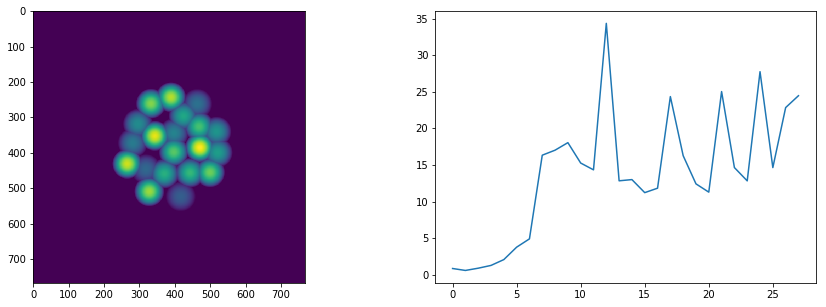

In [14]:
model = Model(zsampling = 'random_grid')  # zsampling options: 'fixed' or 'uniform_random'
Rmat=model(0)

# Save initial values for later comparison 
R_init = Rmat
Tinit,_=make_lenslet_tf(model)
xinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(xinit, model.xpos)


yinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(yinit, model.ypos)

rinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(rinit, model.rlist)

offsetinit = tf.Variable(tf.zeros(model.Nlenslets))
tf.assign(offsetinit, model.lenslet_offset)

model_init=Model()
Rmat_init = model_init(0)
tf.assign(model_init.lenslet_offset, offsetinit)
tf.assign(model_init.xpos, xinit)
tf.assign(model_init.ypos, yinit)
tf.assign(model_init.rlist, rinit)




fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Tinit.numpy())
plt.subplot(1,2,2)
plt.plot(R_init.numpy())

In [ ]:
# dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
# dc_mask[:2,:2] = 0
# dc_mask[-1,0] = 0
# dc_mask[0,-1] = 0
# dc_mask[-1,-1] = 0

# plt.figure()
# plt.imshow(dc_mask)
# plt.colorbar()

In [ ]:
#model.load_weights("C:\\Users\\herbtipa\\lenslets_one_per_depth")
#print(model.dc_mask[-1,:10])

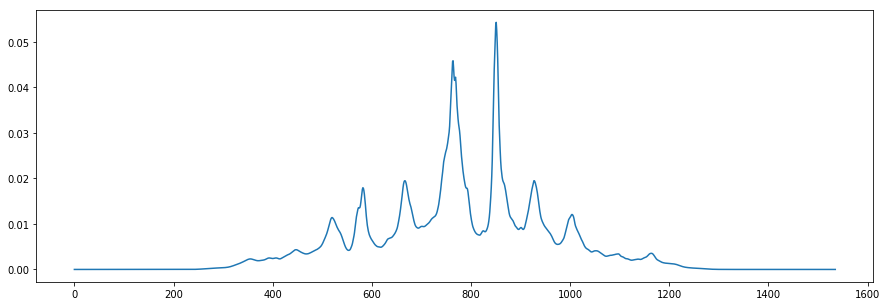

In [15]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
test3=model.gen_correlation_stack(test)
#ax[0].imshow(T)
#plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
#plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
for z in range(10):
    fig = plt.figure(figsize=(15,5))
    plt.cla()
    plt.plot(np.abs(test3[z][model.samples[0],:]))
    
    display.display(fig)
    display.clear_output(wait=True)
    plt.pause(.5)
    
#     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     plt.cla()
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     #plt.imshow(tf_fftshift(np.abs(test[z])))
#     plt.plot(tf_fftshift(tf.abs(test[z]))[768,:])



In [16]:
# Function to return  maximum cross correlation
def calc_max_xcorr(model):
    
    T,aper=make_lenslet_tf(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.5)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    ccor_mx = []
    for zref in range(model.Nz):
        for z in range(model.Nz):
            xcorr12 = tf.real(tf_fftshift(tf.ifft2d(stack_spectrum[zref]* tf.conj(stack_spectrum[z]))))
            if z != zref:
                ccor_mx.append(tf.reduce_max(xcorr12)) 
                    
    return ccor_mx

def re_init_model():
    model.xpos.assign(xinit)
    model.ypos.assign(yinit)

    model.lenslet_offset.assign(offsetinit)
    model.rlist.assign(rinit)

#have tf do everything for us
def loss (model, inputs):
    Rmat = model(inputs)
    return tf.reduce_sum(tf.square(Rmat)), Rmat

def loss_sum(model, inputs):
    Rmat = model(inputs)
    return tf.reduce_sum(Rmat), Rmat

def loss_inf(model, inputs):
    Rmat = model(inputs)
    return tf.reduce_max(Rmat), Rmat

def loss_mixed(model, inputs):
    # max of off diags, sum of diags
    Rmat = model(inputs)
    diag_vec = Rmat[0:model.Nz]
    off_diag = Rmat[model.Nz+1:-1]
    return tf.reduce_sum(tf.abs(diag_vec)) + tf.reduce_max(off_diag), Rmat

def gradient (model, myloss, inputs):
    with tf.GradientTape() as tape:
        lossvalue, Rmat = myloss(model, inputs)
        return tape.gradient(lossvalue, model.variables),lossvalue, Rmat
    
def gradients_and_scaling(model, loss, inputs):
    grad,lossvalue, Rmat=gradient(model,loss, inputs)
    grad[1] = grad[1] * 50000
    grad[2] = grad[2] * 5000
    grad[3] = grad[3] * 5000
    #order=tf.reduce_max((tf.reduce_mean(grad[0]),tf.reduce_mean(grad[1]),tf.reduce_mean(grad[2]),tf.reduce_mean(grad[3])))
    #grad[0]=grad[0]*(order/tf.reduce_mean(grad[0]))
    #grad[1] = grad[1] * (order/tf.reduce_mean(grad[1]))
    #grad[2]=grad[2]* (order/tf.reduce_mean(grad[2]))
    #grad[3]=grad[3]*(order/tf.reduce_mean(grad[3]))
    grads=remove_nan_gradients(grad)
    return grads, lossvalue, Rmat



In [17]:
def averaged_gradient(model, loss, num_averages = 10):

    grad_averaged, lossvalue, Rmat = gradients_and_scaling(model, loss)  # initial value 
    batch_loss = lossvalue
    Rmat_avg = Rmat
    
    for g in range(0, num_averages-1):
        grads, lossvalue, Rmat = gradients_and_scaling(model, loss)
        batch_loss = batch_loss + lossvalue
        Rmat_avg = Rmat_avg + Rmat
        
        
        for grad_ind in range(0,len(model.variables)):
            grad_averaged[grad_ind] = grad_averaged[grad_ind] + grads[grad_ind]


    for grad_ind2 in range(0,len(model.variables)):
            grad_averaged[grad_ind2] = grad_averaged[grad_ind2]*1/num_averages

    batch_loss = batch_loss / num_averages
    Rmat_avg = Rmat_avg/num_averages
    
    return grad_averaged, batch_loss, Rmat_avg

In [18]:
def constrain_distances(model, new_xpos, new_ypos, grads):
    test_dist, test_dist_bool, perm = distances(model, new_xpos, new_ypos)
    grads = np.ones((2,model.Nlenslets))
    for i in range(0,len(perm)):
        if test_dist_bool[i].numpy() == False:
            index = perm[i][0]
            grads[0,index] = 0
            grads[1,index] = 0
    return grads, test_dist, test_dist_bool

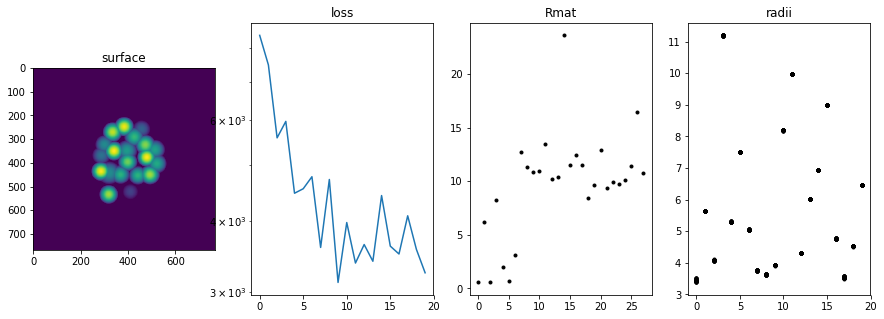

In [19]:
# Options:
step_size = 1e-10   #1e-8 works well for l2
use_averaged_gradient = False  # True: uses averaged gradient, False: uses single gradient 
optimizer_type = 'gd'           # options: 'gd': normal gradient descent, 'nesterov': nesterov acceleration
num_iterations = 10
num_batches = 2

optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
#optimizer=tf.train.MomentumOptimizer(learning_rate=step_size,momentum= 0.9, use_nesterov = True)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]

defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * num_batches)) #mm or dioptres
    

if optimizer_type == 'nesterov':
    tk = tf.constant(1,tf.float32)
    tkp = tf.constant(1,tf.float32)

    #xkp = model.variables
    nvars = np.shape(model.variables)[0]
    xk = []
    xkp = []
    [xk.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [xkp.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

    
for i in range(num_iterations):
    
    defocus_epoch = np.random.permutation(defocus_grid)
    for j in range(0, num_batches):
        if use_averaged_gradient == True:
            grad,lossvalue, Rmat =  averaged_gradient(model, loss, num_averages = 10)
        else: 
            grad, lossvalue, Rmat = gradients_and_scaling(model, loss, defocus_epoch[j*model.Nz:j*model.Nz+model.Nz])  # initial value 


        #grad,lossvalue, Rmat=gradient(model,loss)

       # new_xpos = model.xpos - step_size*grad[2]
       # new_ypos = model.xpos - step_size*grad[3] 
        #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 


        # Gradient step
        if optimizer_type == 'gd':
            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
            # Projection step
            project_to_aper_keras(model)

        if optimizer_type == 'nesterov':

            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())


            # Projection step
            project_to_aper_keras(model)

            # Update variables for next loop
            tk = tkp
            [tf.assign(xk[n],xkp[n]) for n in range(nvars)]

            # Get state after project (gradient_step(yk))
            [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

            #Acceleration
            tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))

            bkp = (tk - 1)/tkp
            ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]


            # Update model variables (yk)
            [model.variables[n].assign(ykp[n]) for n in range(nvars)]




        T,aper=make_lenslet_tf(model)

        losslist.append(lossvalue)

        # Plotting Everything 
        plt.subplot(1,4,1)
        plt.cla()
        plt.imshow(T.numpy())
        plt.title('surface')

        plt.subplot(1,4,2)
        plt.cla()
        plt.semilogy(losslist)
        plt.title('loss')

        plt.subplot(1,4,3)
        plt.cla()
        pl = plt.plot(Rmat.numpy(),'k.')
        plt.title('Rmat')

        plt.subplot(1,4,4)
        #plt.cla()
        pl = plt.plot(model.rlist.numpy(),'k.')
        plt.title('radii')


        display.display(plt.gcf())
        display.clear_output(wait=True)
        pl.clear()
        display.display(plt.gcf())
        display.clear_output(wait=True)
#     pl.remove?
    


#cbar = fig.colorbar(rshow)

In [ ]:
grad

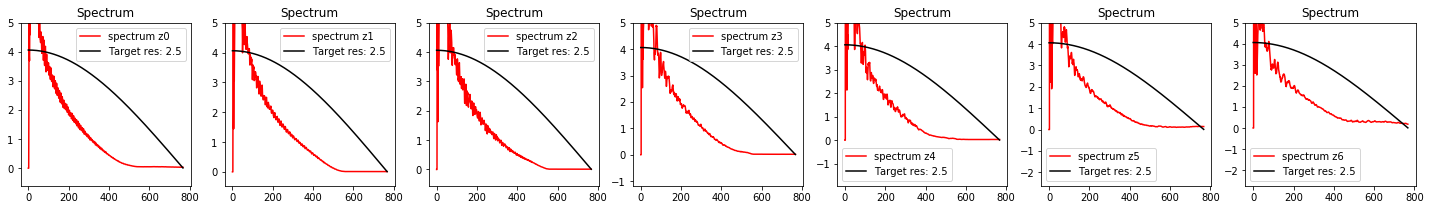

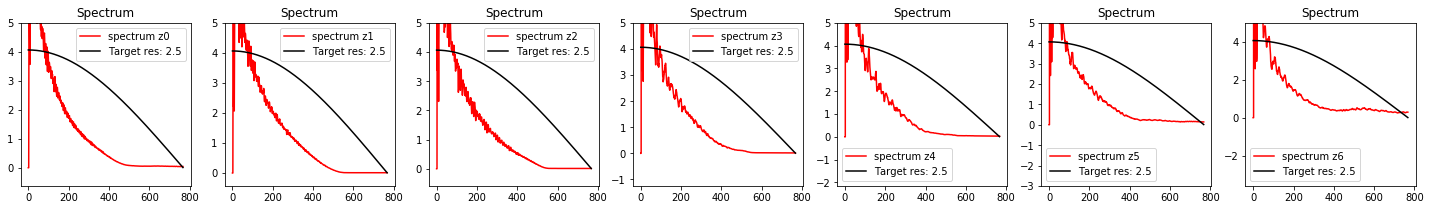

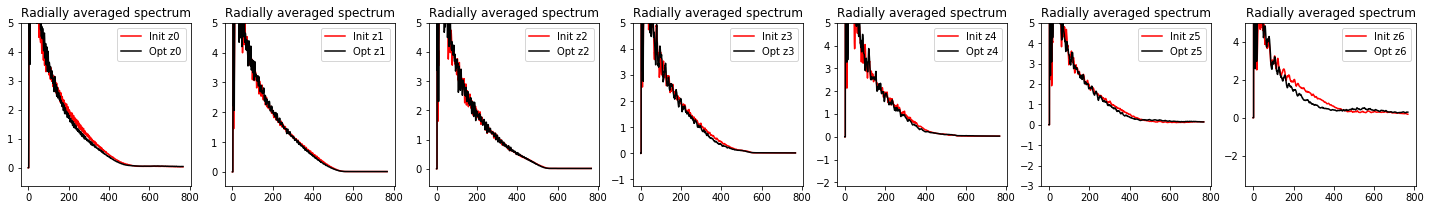

In [20]:
# Compare spectra
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def plot_spectra(model):
    T,aper=make_lenslet_tf(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.5)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        ax[n].plot((model.dc_mask*tf.abs(stack_spectrum[n])).numpy()[0,:model.samples[1]],'r',label='spectrum z{}'.format(n))
        ax[n].plot(model.target_F.numpy()[0,:model.samples[1]],'k',label='Target res: {}'.format(model.target_res))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)
        
def compare_spectra(model_init, model_opt):
    T,aper=make_lenslet_tf(model_init)
    #model = Model()
    psf_stack = model_init.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_init = model_init.gen_stack_spectrum(psf_stack)
    
    T,aper=make_lenslet_tf(model_opt)
    #model = Model()
    psf_stack = model_opt.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_opt = model_opt.gen_stack_spectrum(psf_stack)
    
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        ax[n].plot((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy()[0,:model.samples[1]],'r',label='Initial spectrum z{}'.format(n))
        ax[n].plot((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy()[0,:model.samples[1]],'k',label='Optimized spectrum z{}'.format(n))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)
        
def plot_spectra_radial(model):
    T,aper=make_lenslet_tf(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.5)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        radprof = radial_profile((model.dc_mask*tf.abs(stack_spectrum[n])).numpy(),(0,0))
        ax[n].plot(radprof[:model.samples[1]],'r',label='spectrum z{}'.format(n))
        ax[n].plot(model.target_F.numpy()[0,:model.samples[1]],'k',label='Target res: {}'.format(model.target_res))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)

        
# radial average
def compare_spectra_radial(model_init, model_opt):
    T,aper=make_lenslet_tf(model_init)
    #model = Model()
    psf_stack = model_init.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_init = model_init.gen_stack_spectrum(psf_stack)
    
    T,aper=make_lenslet_tf(model_opt)
    #model = Model()
    psf_stack = model_opt.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_opt = model_opt.gen_stack_spectrum(psf_stack)
    
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        
        radprof_init = radial_profile((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy(),(0,0))
        ax[n].plot(radprof_init[:model_init.samples[1]],'r',label='Init z{}'.format(n))
        #ax[n].plot((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy()[0,:model.samples[1]],'r',label='Initial spectrum z{}'.format(n))
        #ax[n].plot((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy()[0,:model.samples[1]],'k',label='Optimized spectrum z{}'.format(n))
        radprof_opt = radial_profile((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy(),(0,0))
        ax[n].plot(radprof_opt[:model_init.samples[1]],'k',label='Opt z{}'.format(n))
        ax[n].legend()
        ax[n].set_title('Radially averaged spectrum')
        ax[n].set_ylim(top=5)
    
#model_opt = Model()
#model_opt.load_weights('C:\\Users\\herbtipa\\logsumexp_1000_2p5.hd5')
plot_spectra_radial(model_init)


#re_init_model()
plot_spectra_radial(model)
compare_spectra_radial(model_init, model)

Text(0.5, 0, 'z-plane')

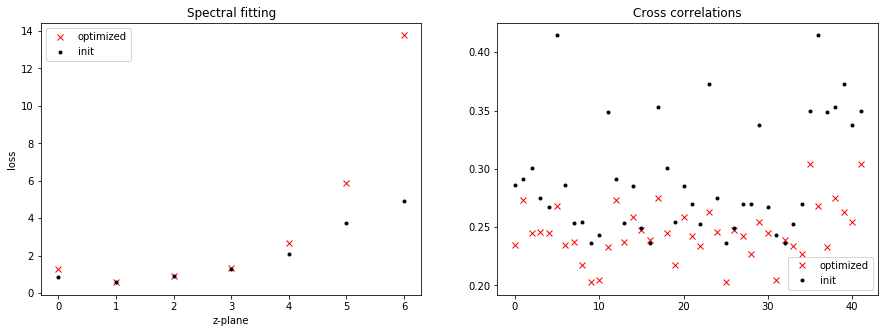

In [22]:
Ropt = model(0).numpy()
xcorr_opt = calc_max_xcorr(model)
Rinit = model_init(0).numpy()
xcorr_init = calc_max_xcorr(model_init)

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ropt[:model.Nz], 'rx',label='optimized')
ax[0].plot(Rinit[:model.Nz],  'k.',label='init')
ax[0].legend()
ax[0].set_title('Spectral fitting')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')


ax[1].plot(xcorr_opt, 'rx',label='optimized')
ax[1].plot(xcorr_init,  'k.',label='init')
ax[1].legend()
ax[1].set_title('Cross correlations')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')

In [ ]:
def plot_psf_stack(model):
    T,aper=make_lenslet_tf(model)
    test2 = model.gen_psf_stack(T, aper, .5)
    test = model.gen_stack_spectrum(test2)
    test3=model.gen_correlation_stack(test)
    #ax[0].imshow(T)
    #plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
    #plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
    for z in range(len(test2)):
        fig = plt.figure(figsize=(15,5))
        plt.cla()
        plt.imshow(test2[z].numpy())
        #plt.plot(np.abs(test3[z][model.samples[0],:]))

        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(.5)


In [ ]:
plot_psf_stack(model)

In [ ]:
def psf_slider(z, psf_stack):
    
    #test = model.gen_stack_spectrum(test2)
    fig = plt.figure(figsize=(15,10))
    plt.imshow(psf_stack[z].numpy())
    plt.show()
    return fig

    

In [ ]:
z_list = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 15)) #mm or dioptres


In [ ]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5, zplanes_opt = z_list)
np.shape(test2[0].numpy())

In [ ]:
from ipywidgets import interact, widgets
fig = plt.figure(figsize=(15,10))
interact(psf_slider, z = widgets.IntSlider(min=1, max = 15, step=1, value=1), test2)

In [ ]:
plot_psf_stack(model)

## Function to run reconstructions in loop (to run many initializations)

In [ ]:
def run_opt(iterations, model, ind, CA):
    
    xpos0 = model.xpos.numpy()
    ypos0 = model.ypos.numpy()
    rlist0 = model.rlist.numpy()
    offset0 = model.lenslet_offset.numpy()
    
    step_size = 1e-8
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)

    losslist=[]
    for i in range(iterations):
        
        num_grads = 10
        grad_averaged = 1/num_grads * gradients_and_scaling(model, loss)
        for g in range(0,num_grads-1):
            grads, lossvalue = gradients_and_scaling(model, loss)
        
            for grad_ind in range(0,len(model.variables)):
                grad_averaged[grad_ind] = grad_averaged[grad_ind] + 1/num_grads * grads[grad_ind]

        
        optimizer.apply_gradients(zip(grads_averaged,model.variables),global_step=tf.train.get_or_create_global_step())
        project_to_aper_keras(model)
        T,aper=make_lenslet_tf(model)

        losslist.append(lossvalue.numpy())
        
    xposf = model.xpos.numpy()
    yposf = model.ypos.numpy()
    rlistf = model.rlist.numpy()
    offsetf = model.lenslet_offset.numpy()    
    save_dict = {'xpos0': xpos0,
             'ypos0': ypos0,
             'rlist0': rlist0,
             'offset0': offset0,
            'losses': losslist,
             'xposf': xposf,
             'yposf': yposf,
             'rlistf': rlistf,
             'offsetf': offsetf,}
    
    save_extension = 'test_'+ str(CA)+ '_' + str(ind)+'_initial_loss_' + str(losslist[0])+ '_final_loss_' + str(losslist[-1]) + '.mat'
    scipy.io.savemat('/home/kyrollos/randoscope/data_1_12_2019/' + save_extension, save_dict)
    

In [ ]:
# Re-initialize model
model.xpos.assign(xinit)
model.ypos.assign(yinit)
model.lenslet_offset.assign(offsetinit)
model.rlist.assign(rinit)
print(model.xpos)

In [ ]:
#[model.variables[n].assign(init_vars) for n in range(nvars)]
# Gradient descent
step_size = 1e-9
optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]
tk = tf.constant(1,tf.float32)
tkp = tf.constant(1,tf.float32)
# xk = model.variables
# xkp = model.variables
# nvars = np.shape(xk)[0]
for i in range(70):
    grad,lossvalue, Rmat=gradient(model,loss_sum)

   # new_xpos = model.xpos - step_size*grad[2]
   # new_ypos = model.xpos - step_size*grad[3] 

    #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 
    #print(new_grad)
    grad[1] = grad[1] * 100000  #Radius
    grad[2]=grad[2]*10000 # X
    grad[3]=grad[3]*10000 # Y
    #grad[2] = grad[2]*new_grad[0,:]*10000
   # grad[3] = grad[3]*new_grad[1,:]*10000   # update the gradient
#    grad[1] = grad[1]*
    
    #grads=remove_nan_gradients(grad)
    #print(grads)
    
    # Gradient step
    optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
    
    # Projection step
    project_to_aper_keras(model)
    

    
    T,aper=make_lenslet_tf(model)

    losslist.append(lossvalue)
    plt.subplot(1,3,1)
    plt.cla()
    #plt.plot(model.xpos.numpy(),model.ypos.numpy(),'o')
    #plt.axis('equal')
    #rmean.append(tf.reduce_mean(model.rlist.numpy()))
    #plt.plot(rmean)
    plt.imshow(T.numpy())
    plt.subplot(1,3,2)
    plt.cla()
    plt.semilogy(losslist)
    
    
    plt.subplot(1,3,3)
    plt.cla()

    #rshow = plt.imshow(np.tril(Rmat[model.Nz+1:-1])
#     cbar = fig.colorbar(rshow)    
    pl = plt.plot(Rmat.numpy(),'k.')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    pl.clear()
#     cbar.remove()
# cbar = fig.colorbar(rshow)

In [ ]:
fig = plt.figure(figsize=(15,3))
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
test4=model.gen_correlation_stack(test)
#ax[0].imshow(T)


# for z in range(len(test4)):

#     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     plt.cla()
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     plt.subplot(1,2,1)
#     plt.plot(np.abs(test3[z][model.samples[0],:]))
    
#     plt.subplot(1,2,2)
#     plt.plot(np.abs(test4[z][model.samples[0],:]))

#     display.display(fig)
#     display.clear_output(wait=True)
#     plt.pause(.5)

In [ ]:
plt.figure(figsize=(20,15))
for z in range(7):

    #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
    #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
    #plt.cla()
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
    plt.subplot(7,2,z*2+1)
    ind = (model.Nz+1) * (z)
    plt.plot(np.abs(test3[ind][model.samples[0],:]))
    
    plt.subplot(7,2,z*2+2)
    plt.plot(np.abs(test4[ind][model.samples[0],:]))

    #display.display(fig)
    #display.clear_output(wait=True)
    #plt.pause(.5)

In [ ]:
plt.imshow(tf.reshape(model(0),(model.Nz, model.Nz)))
plt.colorbar()

In [ ]:
plt.plot(np.sort(1/model.rlist.numpy()),'o')

In [ ]:
model.lenslet_offset

In [ ]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, 0.5)
test = model.gen_stack_spectrum(test2)
fig = plt.figure()

f,ax = plt.subplots(1,2,figsize=(20,20))

ax[0].imshow(T)


for z in range(model.Nz):
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))) - model.target_F, vmax = 50)
    im_disp = ax[1].imshow((tf.real((test2[z]))),vmax = .3)
    cbar = plt.colorbar(im_disp, ax=ax[1])
    display.display(f)
    display.clear_output(wait=True)
    cbar.remove()
    #plt.pause(1)

In [ ]:
def animate_zstack(i):
#    ax[1].clear()
    ax[1].imshow(tf.real(test2[i]),vmax = .1)

In [ ]:
#model.save_weights('C:\\Users\\herbtipa\\lenslets_one_per_depth.hd5',overwrite=False)

In [ ]:
f,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(T)
ani = animation.FuncAnimation(f, animate_zstack, frames = range(model.Nz), interval = 500, repeat = False)
# plt.show(ani)
#Writer = animation.writers['ffmpeg']

# HTML(ani.to_html5_video())
for i in range(model.Nz):
    animate_zstack(i)
    display.display(f)
    display.clear_output(wait=True)
    f.savefig('C:\\Users\\herbtipa\\foo_{}.png'.format(i))
    



In [ ]:
#jacobian=[]
#for i in range (model.Nz**2):
#    with tf.GradientTape() as tape:
#        #tape.watch(model.variables)
#        R=model(0)
#        jacobian.append(tape.gradient(R[i], model.variables))
